# Face Detection with Amazon SageMaker

This notebook provides an overview at how Amazon SageMaker effortlessly simplifies the machine learning development cycle for even the most complex of models, such as the Single Shot Detector (SSD) for Face Detection.

Amazon SageMaker is a fully-managed service that simplifies the process of **building**, **training**, and **deploying** machine learning and deep learning models at scale. It consists of three components:

* **Build**: A fully managed Jupyter Notebook instance for loading data, prototyping models, and launching training jobs and deployment endpoints. This comes pre-configured with all of the standard deep learning libraries for both CPU and GPU computation. 
* **Train**: With one-click, SageMaker launches fully managed, scalable training jobs on AWS for both proprietary SageMaker ML algorithms and custom-designed deep learning architectures.
* **Deploy**: With one-click SageMaker provides a fully managed service for deploying trained models to endpoint instances to host model inference as an API call.

### Set-up
#### Imports

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNet, MXNetModel
import matplotlib.pyplot as plt
import pickle
import cv2
import random
import numpy as np
from PIL import Image
import urllib
%matplotlib inline

## Build

The SageMaker Notebook instance is a convenient platform to explore data for a given task and preprocess if necessary.
We can use this environment to easily launch training jobs using this data, and deploy trained models for inference.

### Data Exploration

Our model is tasked with Face Detection. Training a deep learning model to accomplish any task requires inputs (or observations), and outputs (or labels). Let's look at what these are.

The data set the model will be trained on is a set of images as inputs:

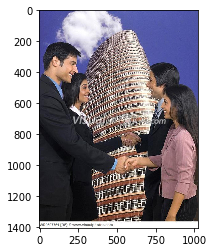

In [2]:
img_array = np.array(Image.open('1_Handshaking_Handshaking_1_203.jpg'))
plt.imshow(img_array)

With a corresponding set of numbers as outputs:

In [3]:
# 1--Handshaking/1_Handshaking_Handshaking_1_203.jpg
# 4
# 142.756032 258.058981 112.557641 216.879357
# 241.587131 433.758713 90.595174 161.973190
# 691.817694 387.088472 82.359249 178.445040
# 782.412869 527.099196 85.104558 175.699732

The numbers here describe bounding boxes for the four faces in the image.

Each row represents: <tt>left top width height</tt>. 

Let's visualize what these bounding box coordinates look like:

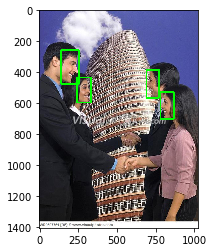

In [4]:
boxes = [
         [int(np.round(142.756032)), int(np.round(258.058981)), int(np.round(112.557641)), int(np.round(216.879357))],
         [int(np.round(241.587131)), int(np.round(433.758713)), int(np.round(90.595174)), int(np.round(161.973190))],
         [int(np.round(691.817694)), int(np.round(387.088472)), int(np.round(82.359249)), int(np.round(178.445040))],
         [int(np.round(782.412869)), int(np.round(527.099196)), int(np.round(85.104558)), int(np.round(175.699732))]
        ]
for box in boxes:
    img_array = cv2.rectangle(img_array,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),(0,255,0),10)
plt.imshow(img_array)

Like image classification, face detections is a supervised training task. Here, the inputs are the images and the outputs are the bounding box coordinates.

MXNet lets us convert images into a binary Record format that makes I/O blazing fast, and we'll use this format to train our model in the next step.

## Train

Like image classification, face detections is a supervised training task. Here, the inputs are the images and the outputs are the bounding box coordinates.

MXNet lets us convert images into a binary Record format that makes I/O blazing fast, and we'll use this format to train our model in the next step.

Now that we understand our data and what the task is, we can launch a training job on SageMaker. To do that, we need to create our SageMaker session object and our execution role with the following methods that inherit the credentials/ARN from the notebook environment:

In [5]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

(**Note**: Most of the code for this section is included here as markdown to prevent errors. You likely will not have the instance limit to train the model on the <tt>ml.p3.xlarge</tt> instance required. Once you do, feel free to copy code into new cells to run on your own.)

Next, we need to put the data set on S3 so SageMaker can pull the data set onto the instances it spins up for training.

The data has been pre-loaded into S3, so we'll use it's address as the location of our inputs.

``` python
inputs = "s3://sagemaker-obj-det-demo/ssd-data"
```

Next, we can easily launch a training job by defining a custom <tt>MXNet</tt> estimator, through which we specify custom training code and hyperparameters, as well as the type and number of instances we wish to train on at once.

Tuning hyperparameters and launching distributed training jobs is as simple as changing these arguments below.
``` python
net_sagemaker = MXNet("mxnet_ssd_face_detection_rekognition.py", 
                  role=role, 
                  train_instance_count=1, 
                  train_instance_type="ml.p3.xlarge",
                  sagemaker_session=sagemaker_session,
                  hyperparameters={
                                 'batch_size': 8, 
                                 'epochs': 1, 
                                 'learning_rate': 0.004, 
                                 'num_gpus': 1
                                  })
```                              

With a single click, we can launch a training job, distributed or otherwise, and SageMaker completely handles the resource management to do so. (**Note**: We have chosen a p3 instance here because GPU compute is typically used for training neural networks. However, comparable speeds can be accomplished with the c5 instance type).

When launching a training job, SageMaker:
* Creates an S3 bucket to store training script <tt>mxnet_ssd_face_detection.py</tt>
* Launches an EC2 instance(s) for training
* Pulls down data in S3 and training script
* Runs the training loop defined in the <tt>train_fn</tt> method in our training script, <tt>mxnet_ssd_face_detection.py</tt>
* The model begins to train, logging the training loss and metrics every 200 iterations. We are only training for one epoch, but it is enough to see that the loss is indeed being minimized
```python
net_sagemaker.fit(inputs)
```
```
INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-py2-gpu-2018-02-28-17-16-33-533
.............................................................................................................
executing startup script (first run)
2018-02-28 17:25:31,635 INFO - root - running container entrypoint
2018-02-28 17:25:31,636 INFO - root - starting train task
2018-02-28 17:25:33,283 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'mxnet_ssd_face_detection.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'mxnet_ssd_face_detection.py', u'num_gpus': 1, u'learning_rate': 0.004, u'batch_size': 8, u'epochs': 1, u'sagemaker_submit_directory': u's3://sagemaker-us-east-1-288000045208/sagemaker-mxnet-py2-gpu-2018-02-28-17-16-33-533/source/sourcedir.tar.gz', u'sagemaker_region': u'us-east-1', u'sagemaker_enable_cloudwatch_metrics': False, u'sagemaker_job_name': u'sagemaker-mxnet-py2-gpu-2018-02-28-17-16-33-533', u'sagemaker_container_log_level': 20}, 'hosts': [u'algo-1'], '_scheduler_ip': '10.32.0.4', '_ps_port': 8000, 'user_script_archive': u's3://sagemaker-us-east-1-288000045208/sagemaker-mxnet-py2-gpu-2018-02-28-17-16-33-533/source/sourcedir.tar.gz', '_scheduler_host': u'algo-1', 'sagemaker_region': u'us-east-1', 'input_dir': '/opt/ml/input', 'user_requirements_file': None, 'current_host': u'algo-1', 'container_log_level': 20, 'available_cpus': 4, 'base_dir': '/opt/ml'}
Downloading s3://sagemaker-us-east-1-288000045208/sagemaker-mxnet-py2-gpu-2018-02-28-17-16-33-533/source/sourcedir.tar.gz to /tmp/script.tar.gz
2018-02-28 17:25:33,421 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.170.2
2018-02-28 17:25:33,532 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): s3.amazonaws.com
2018-02-28 17:25:33,700 INFO - mxnet_container.train - Starting distributed training task
[17:25:33] src/io/iter_image_det_recordio.cc:109: Loaded ImageList from /opt/ml/input/data/training/WIDER/imglists/img.lst 9764 Image records
[17:25:33] src/io/iter_image_det_recordio.cc:280: ImageDetRecordIOParser: /opt/ml/input/data/training/WIDER/imglists/img.rec, use 3 threads for decoding..
[17:25:33] src/io/iter_image_det_recordio.cc:333: ImageDetRecordIOParser: /opt/ml/input/data/training/WIDER/imglists/img.rec, label padding width: 47
2018-02-28 17:25:35,511 INFO - root - Start training with (gpu(0)) from pretrained model /opt/ml/input/data/training/resnet50
[17:25:35] src/nnvm/legacy_json_util.cc:190: Loading symbol saved by previous version v0.8.0. Attempting to upgrade...
[17:25:35] src/nnvm/legacy_json_util.cc:198: Symbol successfully upgraded!
('class names', None)
[17:25:40] src/operator/././cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
2018-02-28 17:27:10,975 INFO - root - Epoch[0] Batch [200]#011Speed: 20.82 samples/sec#011CrossEntropy=0.718993#011SmoothL1=0.947702
2018-02-28 17:28:28,582 INFO - root - Epoch[0] Batch [400]#011Speed: 20.62 samples/sec#011CrossEntropy=0.591629#011SmoothL1=0.768214
2018-02-28 17:29:46,152 INFO - root - Epoch[0] Batch [600]#011Speed: 20.63 samples/sec#011CrossEntropy=0.562738#011SmoothL1=0.594910
2018-02-28 17:31:03,575 INFO - root - Epoch[0] Batch [800]#011Speed: 20.67 samples/sec#011CrossEntropy=0.563186#011SmoothL1=0.620748
2018-02-28 17:32:21,113 INFO - root - Epoch[0] Batch [1000]#011Speed: 20.64 samples/sec#011CrossEntropy=0.546006#011SmoothL1=0.568926
2018-02-28 17:33:38,554 INFO - root - Epoch[0] Batch [1200]#011Speed: 20.66 samples/sec#011CrossEntropy=0.542997#011SmoothL1=0.507137
2018-02-28 17:33:46,326 INFO - root - Epoch[0] Train-CrossEntropy=0.475800
2018-02-28 17:33:46,326 INFO - root - Epoch[0] Train-SmoothL1=0.324509
2018-02-28 17:33:46,326 INFO - root - Epoch[0] Time cost=472.544
===== Job Complete =====
```

## Deploy

We've trained our model here for a single epoch in the interest of time, but in reality we would want to run this overnight, which we've already done. After this, we'd make some modifications to our model to convert it from training format to inference.

We've done this already, and will use SageMaker to deploy this model to an endpoint that will run inference on data requests. To do this, we need to provide a custom script that the serving container uses as an entrypoint. This script will contain the code for transforming requests we send to it.

We can use the <tt>%%writefile</tt> command in a jupyter notebook cell to actually write code to a file, so let's start writing this script piece by piece.

First, we'll write the imports to the file.

In [22]:
%%writefile mxnet_ssd_face_detection_rekognition.py
from __future__ import absolute_import
import mxnet as mx
import random
import datetime
import json
import time
import numpy as np
import boto3
import urllib

urllib.urlretrieve ("https://raw.githubusercontent.com/drj11/pypng/master/code/png.py", "png.py")
import png

Overwriting mxnet_ssd_face_detection_rekognition.py


Next, we'll start writing the code we need to host the model and transform requests. First, we'll add a function <tt>push_to_s3</tt> that pushes crops of detected faces to S3 bucket "YOUR-BUCKET". 

**Note**: Please replace "YOUR-BUCKET" with the bucket created in an earlier step:

In [23]:
%%writefile -a mxnet_ssd_face_detection_rekognition.py

###############################
###     Hosting Code        ###
###############################

def push_to_s3(img, index):
    bucket_name = "YOUR-BUCKET"

    timestamp = int(time.time())
    now = datetime.datetime.now()
    key = "faces/{}_{}/{}_{}/{}_{}.jpg".format(now.month, now.day,
                                               now.hour, now.minute,
                                               timestamp, index)

    s3 = boto3.client('s3')

    png.from_array(img.astype(np.uint8), 'RGB').save('img.png')
    response = s3.put_object(ACL='public-read',
                         Body=open('img.png', 'rb'),
                         Bucket=bucket_name,
                         Key=key)

Appending to mxnet_ssd_face_detection_rekognition.py


Next, we define a function <tt>model_fn</tt> for loading the model:

In [14]:
%%writefile -a mxnet_ssd_face_detection_rekognition.py

def model_fn(model_dir):
    sym, arg_params, aux_params = mx.model.load_checkpoint('%s/model/deploy_ssd' % model_dir, 0)
    net = mx.mod.Module(sym, label_names=None)
    net.bind(data_shapes=[('data', (1, 3, 300, 300))])
    net.set_params(arg_params, aux_params)
    return net

Appending to mxnet_ssd_face_detection_rekognition.py


Finally, we'll write the function <tt>transform_fn</tt>. This function provides the logic that SageMaker uses to handle requests. In this instance, we're going to not only run inference on our inputs, but we're going to take the face crops detected (if any) and save them to an S3 bucket

In [15]:
%%writefile -a mxnet_ssd_face_detection_rekognition.py

def transform_fn(net, data, input_content_type, output_content_type):
    img = np.array(json.loads(data))
    batch = mx.io.DataBatch([mx.nd.array(np.expand_dims(np.transpose(img, (2, 0, 1)), 0))])
    net.forward(batch)
    dets = net.get_outputs()[0].asnumpy()
    response_body = json.dumps(dets.tolist()[0])
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    dets = dets[0]
    for i in range(dets.shape[0]):
        cls_id = int(dets[i, 0])
        if cls_id >= 0:
            score = dets[i, 1]
            if score > 0.5:
                if cls_id not in colors:
                    colors[cls_id] = (random.random(), random.random(), random.random())
                xmin = int(dets[i, 2] * width)
                ymin = int(dets[i, 3] * height)
                xmax = int(dets[i, 4] * width)
                ymax = int(dets[i, 5] * height)
                crop_img = img[ymin:ymax, xmin:xmax]
                push_to_s3(crop_img, i)            
    return response_body, output_content_type

Appending to mxnet_ssd_face_detection_rekognition.py


Now let's look at the whole script:

In [ ]:
!cat mxnet_ssd_face_detection_rekognition.py

Next, we'll define the model object that we'll use to deploy the serving container, using the inference script we just made as an entry point.

In [17]:
mxnet_model = MXNetModel(model_data="s3://sagemaker-obj-det-demo/model.tar.gz",
                         role=role, entry_point="mxnet_ssd_face_detection_rekognition.py",
                        py_version='py2')

We'll now continue to deploy.

As before, the actual deployment will take only one click; SageMaker takes care of launching the instances and the server itself.

**Note**: When deploying an endpoint, SageMaker must spin up an instance (or instances). This may take some time; once finished, the dash marks below will end in an exclamation point.

In [18]:
predictor = mxnet_model.deploy(instance_type="ml.c5.xlarge", initial_instance_count=1)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-06-15-23-23-38-750
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2018-06-15-23-23-38-750


--------------------------------------------------------------!

Once we've deployed the inference endpoint, we can start calling it by sending requests with serialized image data. If any faces are detected, the endpoint wil push face crops to the S3 bucket you specified.

In [19]:
test_img_array = np.array(Image.open('19_Couple_Couple_19_187.jpg'))
test_img_array = cv2.resize(test_img_array, (300, 300))

response = np.array(predictor.predict(test_img_array.tolist()))

The response we recieve is a series of possible face detections (coordinates are percentage of dimensions):
<tt>[id, score, xmin, ymin, xmax, ymax]</tt>

We only have one class so <tt>id</tt> will always be zero. However, we can set a threshold for what level of confidence we want to have to include face detections as valid. Let's plot the results.

In [20]:
def plot_prediction(dets, img, thresh=0.5):
    classes = ['face']
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    for i in range(dets.shape[0]):
        cls_id = int(dets[i, 0])
        if cls_id >= 0:
            score = dets[i, 1]
            if score > thresh:
                if cls_id not in colors:
                    colors[cls_id] = (random.random(), random.random(), random.random())
                xmin = int(dets[i, 2] * width)
                ymin = int(dets[i, 3] * height)
                xmax = int(dets[i, 4] * width)
                ymax = int(dets[i, 5] * height)
                rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                     ymax - ymin, fill=False,
                                     edgecolor=colors[cls_id],
                                     linewidth=3.5)
                plt.gca().add_patch(rect)
                class_name = str(cls_id)
                if classes and len(classes) > cls_id:
                    class_name = classes[cls_id]
                plt.gca().text(xmin, ymin - 2,
                                '{:s} {:.3f}'.format(class_name, score),
                                bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                fontsize=12, color='white')
    plt.show()

The plot shows the bounding box around the identified face, as well as the confidence level of the prediction.

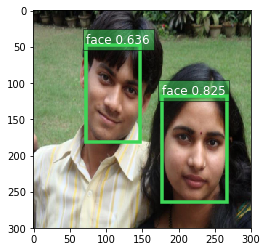

In [21]:
plot_prediction(response, test_img_array)